**MPPI Optimization Loop Demo**

# **Installations**

In [2]:
!git clone https://github.com/sdean-group/balloon-outreach.git
%cd balloon-outreach
!git checkout v0

Cloning into 'balloon-outreach'...
remote: Enumerating objects: 690, done.
remote: Counting objects: 100% (330/330), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 690 (delta 200), reused 229 (delta 161), pack-reused 360 (from 1)
Receiving objects: 100% (690/690), 34.63 MiB | 11.15 MiB/s, done.
Resolving deltas: 100% (410/410), done.
/content/balloon-outreach
Already on 'v0'
Your branch is up to date with 'origin/v0'.


In [3]:
# Install required packages
!pip install -r requirements.txt
!pip install -U gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.0/268.0 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.2 MB/s eta 0:00:00
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268067 sha256=92cd5fe661acf6aa8cfd2a4be1fdbc65616198ed639606a903c641e70c86e964
  Stored in directory: /root/.cache/pip/wheels/17/3c/41/2bc89719586c2a5c53e9a527daa76a968a1288315c1ae2d904
Successfully built reverse_geocoder


In [4]:
# Download ERA5 data
import gdown
file_id = "1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf"
url = f"https://drive.google.com/uc?id={file_id}"
output = "era5_data.nc"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf
From (redirected): https://drive.google.com/uc?id=1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf&confirm=t&uuid=aac0e3d6-478e-499e-be4c-d0bd91ba30e8
To: /content/balloon-outreach/era5_data.nc
100%|██████████| 1.65G/1.65G [00:19<00:00, 84.5MB/s]


'era5_data.nc'

# **Sampling Demo**

Below is a walkthrough of one iteration of the MPPI optimization loop for a given control sequence:

In [9]:
import os
import sys
import numpy as np

os.chdir('/content/balloon-outreach')
sys.path.append('/content/balloon-outreach')

from main_mppi import run_episode
from env.balloon_env import BalloonEnvironment
from agent.mppi_agent import MPPIAgent
import matplotlib.pyplot as plt

initial_lat = 0
initial_lon = 0
initial_alt = 12.0
target_lat = 5
target_lon = 10
target_alt = 12
max_steps = 100
env = BalloonEnvironment(target_lat=target_lat, target_lon=target_lon,target_alt=target_alt)
agent = MPPIAgent(num_samples=10, acc_bounds=(-0.1,0.1), visualize=False)

horizon = 10
control_sequence = np.zeros(horizon) # our plan of velocities for the balloon

# 1. Sample random control sequences
vertical_velocity = env.balloon.vertical_velocity
base_sequence = control_sequence.copy()
# Add noise to create samples
noise = np.random.normal(0, agent.noise_std, (agent.num_samples, agent.horizon))

acc_samples = base_sequence + noise
acc_samples = np.clip(acc_samples, agent.acc_bounds[0], agent.acc_bounds[1])
print(f"Acceleration samples are:")
for sample in acc_samples:
  print(sample)
accumulated_acc_samples = np.cumsum(acc_samples, axis=1)
vel_samples = vertical_velocity + accumulated_acc_samples

# Clip to action bounds
vel_samples = np.clip(vel_samples, agent.vel_bounds[0], agent.vel_bounds[1])
print("-------------------------------")
print(f"Velocity samples are:")
for sample in vel_samples:
  print(sample)

Acceleration samples are:
[-0.07979702  0.01092598 -0.08122625  0.1         0.05533951  0.01333631
  0.09225467 -0.07872083  0.1         0.05741686]
[ 0.05352877 -0.1        -0.1         0.07018407 -0.1         0.02728689
  0.04322984  0.0198316  -0.1         0.07515982]
[-0.05591022 -0.0184091  -0.08045586  0.00776016 -0.01060597  0.03895393
 -0.00632761  0.05121089 -0.06302423 -0.08236135]
[-0.1        -0.04362743 -0.1         0.06514262  0.08948212 -0.09424937
 -0.02545999 -0.1        -0.1         0.01519821]
[ 0.1        -0.09711451  0.07992427 -0.1         0.1        -0.1
 -0.1         0.05967518 -0.06219905 -0.02973683]
[ 0.1         0.0777651  -0.1        -0.1        -0.09382037 -0.05689648
  0.1         0.1        -0.1        -0.02696803]
[ 0.1        -0.09803176 -0.04319991  0.09379808 -0.01434299  0.05579268
  0.06980467  0.1        -0.0318615  -0.1       ]
[-0.02810615  0.02305502  0.01764251 -0.01226818 -0.1         0.04727386
 -0.03389592 -0.08012926  0.05335408 -0.0935146

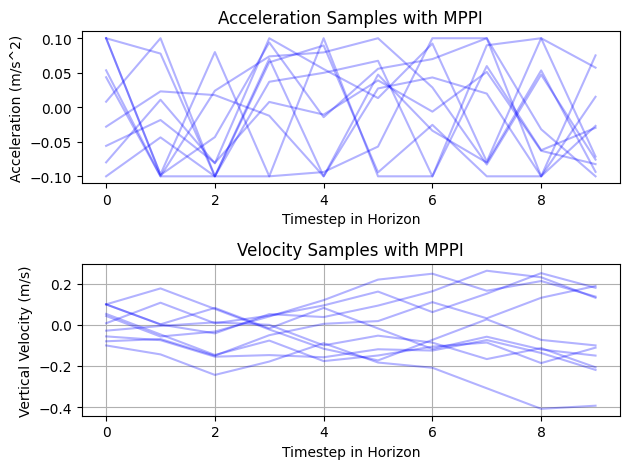

In [10]:
# Graph the samples
fig = plt.figure()

plt.subplot(2,1,1)
for acc_sample in acc_samples:
    plt.plot([i for i in range(horizon)], acc_sample, 'b-', alpha=0.3)
plt.title(f'Acceleration Samples with MPPI')
plt.xlabel('Timestep in Horizon')
plt.ylabel('Acceleration (m/s^2)')

plt.subplot(2,1,2)
for vel_sample in vel_samples:
    plt.plot([i for i in range(horizon)], vel_sample, 'b-', alpha=0.3)
plt.title(f'Velocity Samples with MPPI')
plt.xlabel('Timestep in Horizon')
plt.ylabel('Vertical Velocity (m/s)')

plt.grid(True)
plt.tight_layout()
plt.savefig('samples.png')
plt.show()
plt.close()

In [11]:

# 2. Calculate cost of each sequence
costs = []
for i in range(horizon):
    # Evaluate one sample control sequence
    cost = 0.0
    trajectory = []
    vel_sample = vel_samples[i]
    acc_sample = acc_samples[i]

    cost, _ = agent._evaluate_control_sequence(acc_sample,vel_sample, [], env)
    costs.append(cost)

costs = np.array(costs)

# Check for NaN costs and replace with high cost
if np.any(~np.isfinite(costs)):
    print("Warning: NaN costs detected, replacing with high cost")
    costs = np.where(np.isfinite(costs), costs, 1e6)
print(f"Costs are: {costs}")

# 3. Use the costs to calculate weights for each sampled sequence
# Shift costs to prevent numerical issues
costs_shifted = costs - np.min(costs)

# Compute weights using softmax
weights = np.exp(-1 * costs_shifted)
weights = weights / np.sum(weights)

# Check for NaN weights
if np.any(~np.isfinite(weights)):
    print("Warning: NaN weights detected, using uniform weights")
    weights = np.ones_like(weights) / len(weights)
print(f"Weights are: {weights}")


Costs are: [111.78251934 111.78251934 111.78251935 111.78251935 111.78251933
 111.78251932 111.78251933 111.78251934 111.78251933 111.78251932]
Weights are: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


Final control sequence: [ 0.01412577 -0.0104179  -0.05875385 -0.03522891 -0.02968198 -0.01979679
 -0.01296231 -0.00508357 -0.02073605 -0.0539297 ]


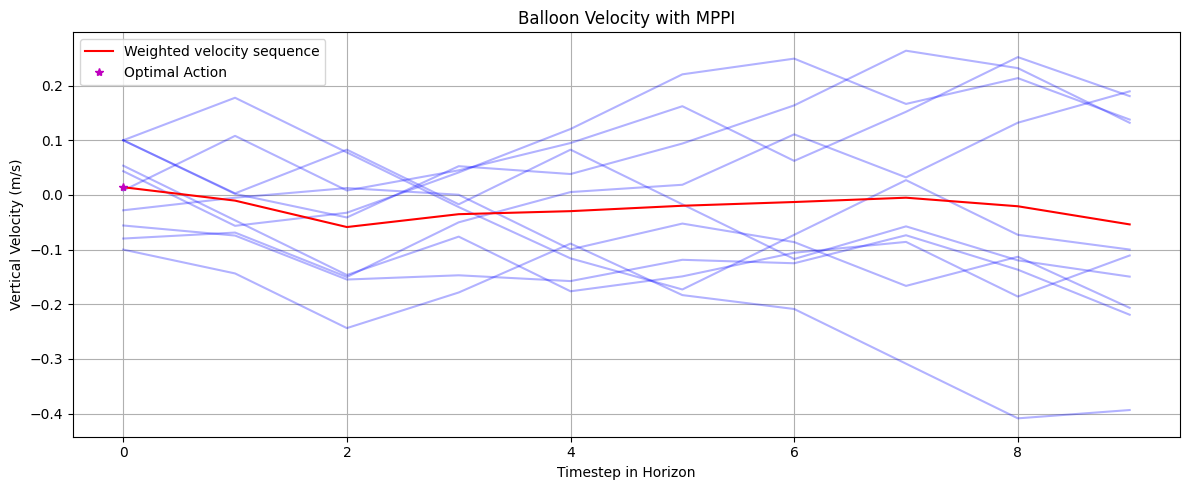

In [12]:
# 4. Compute optimal control sequence by weighted averaging
optimal_sequence = np.average(vel_samples, axis=0, weights=weights)
# Check for NaN in optimal control
if not np.isfinite(optimal_sequence[0]):
    print("Warning: NaN optimal control detected, using zero action")
    optimal_sequence[0] = 0.0

# 5. Update control sequence
#control_sequence = np.roll(optimal_sequence, -1)
#control_sequence[-1] = optimal_sequence[0]
control_sequence = optimal_sequence

print(f"Final control sequence: {control_sequence}")
# Plot final trajectory
plt.figure(figsize=(12, 5))

# Position plot
#plt.subplot(1, 2, 1)
for vel_sample in vel_samples:
    plt.plot([i for i in range(horizon)], vel_sample, 'b-', alpha=0.3)
plt.plot([i for i in range(horizon)], control_sequence, 'r-', alpha=1, label='Weighted velocity sequence')
plt.plot(0, control_sequence[0], 'm*', label='Optimal Action')
plt.grid(True)
plt.title(f'Balloon Velocity with MPPI')
plt.xlabel('Timestep in Horizon')
plt.ylabel('Vertical Velocity (m/s)')
plt.legend()

plt.tight_layout()
plt.savefig('velocity.png')
plt.show()
plt.close()


The graph should change slightly each time you run it since the generated samples are random. The optimal action the agent selects is the first velocity from the control sequence.

# **Iterative Optimization**

MPPI normally optimizes once per timestep. However, we can repeat this optimization loop `num_iterations` times to try to get a better control sequence. For each loop, once we get the optimal control sequence, we pass this in as the initial control sequence to re-optimize.

Optimized control sequence: [ 0.03119019  0.04611225  0.0338733  -0.0011729   0.03983371  0.04165121
  0.04761067  0.05443875  0.0664179   0.09123383]
Optimized control sequence: [0.01347324 0.03812104 0.07254488 0.091216   0.10497176 0.12306378
 0.15203418 0.20988958 0.28879142 0.32590974]
Optimized control sequence: [-0.02967875  0.03474091  0.08306447  0.11572131  0.16370812  0.21572012
  0.2996937   0.3996937   0.49006373  0.59006373]
Optimized control sequence: [-0.0503923  -0.02085112  0.00876157  0.08147664  0.17588809  0.27512471
  0.37344852  0.47344852  0.57344852  0.67344852]
Optimized control sequence: [-0.02684943 -0.04868275 -0.06477875  0.00684029  0.07412101  0.17412101
  0.27412101  0.37412101  0.47412101  0.57412101]
Optimized control sequence: [-0.06069426 -0.10698255 -0.17316779 -0.11846057 -0.04995957  0.04322124
  0.13598732  0.23598732  0.33598732  0.43598732]
Optimized control sequence: [-0.04609738 -0.12345252 -0.19917698 -0.25869047 -0.26015408 -0.23841728
 -0

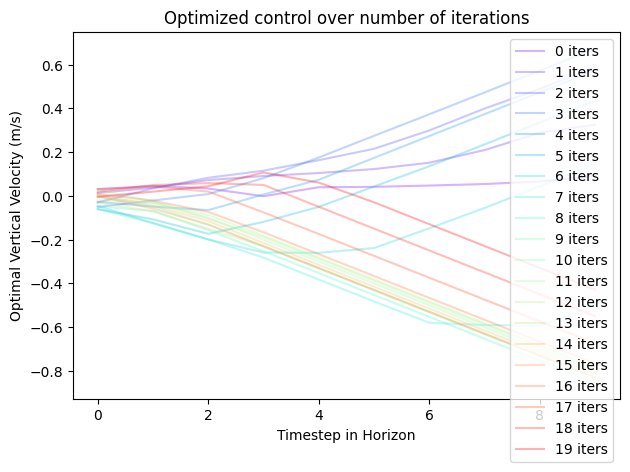

In [14]:
from matplotlib.pyplot import cm
import numpy as np

num_iterations = 10
horizon = 10
control_sequence = np.zeros(horizon)
color = iter(cm.rainbow(np.linspace(0, 1, num_iterations)))

for num in range(num_iterations):
  vertical_velocity = env.balloon.vertical_velocity
  base_sequence = control_sequence.copy()
  # Add noise to create samples
  noise = np.random.normal(0, agent.noise_std, (agent.num_samples, agent.horizon))

  acc_samples = base_sequence + noise
  acc_samples = np.clip(acc_samples, agent.acc_bounds[0], agent.acc_bounds[1])
  accumulated_acc_samples = np.cumsum(acc_samples, axis=1)
  vel_samples = vertical_velocity + accumulated_acc_samples
  vel_samples = np.clip(vel_samples, agent.vel_bounds[0], agent.vel_bounds[1])
  costs = []
  for i in range(horizon):
      # Evaluate one sample control sequence
      cost = 0.0
      trajectory = []
      vel_sample = vel_samples[i]
      acc_sample = acc_samples[i]

      cost, _ = agent._evaluate_control_sequence(acc_sample,vel_sample, [], env)
      costs.append(cost)

  costs = np.array(costs)

  # Check for NaN costs and replace with high cost
  if np.any(~np.isfinite(costs)):
      print("Warning: NaN costs detected, replacing with high cost")
      costs = np.where(np.isfinite(costs), costs, 1e6)

  costs_shifted = costs - np.min(costs)
  weights = np.exp(-1 * costs_shifted)
  weights = weights / np.sum(weights)

  # Check for NaN weights
  if np.any(~np.isfinite(weights)):
      print("Warning: NaN weights detected, using uniform weights")
      weights = np.ones_like(weights) / len(weights)

  optimal_sequence = np.average(vel_samples, axis=0, weights=weights)
  # Check for NaN in optimal control
  if not np.isfinite(optimal_sequence[0]):
      print("Warning: NaN optimal control detected, using zero action")
      optimal_sequence[0] = 0.0

  control_sequence = optimal_sequence
  c = next(color)
  pltlabel = f"{num} iters"
  plt.plot([i for i in range(horizon)], control_sequence, c=c, alpha=0.3, label=pltlabel)
  print(f"Optimized control sequence: {control_sequence}")

plt.title('Optimized control over number of iterations')
plt.xlabel('Timestep in Horizon')
plt.ylabel('Optimal Vertical Velocity (m/s)')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

Try to adjust the `num_iterations` variable to see how the optimized control sequence changes! Does it seem to converge?